In [1]:
# Import modules

import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from dimod import BinaryQuadraticModel
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler
from dwave.system import DWaveSampler, FixedEmbeddingComposite
import dwave_networkx as dnx
import dwave.inspector

from plotters import plotHistogram, plotBoundaryStrength, plotSampleGraph, plotArrangement, annotateSampleGraph
from qubo import createBQM

In [2]:
identifier = "Haydn"
path = path = f"../Pickles/{identifier}/{identifier}_"

instruments = json.load(open(path + "instruments.json"))
phrases = pickle.load(open(path + "phrases.pkl", "rb"))
G = nx.read_graphml(path + "graph.graphml")
bqm = BinaryQuadraticModel.from_serializable(json.load(open(path + "bqm.json", "r")))
embedding = json.load(open(path + "embedding.json", "r"))

sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
reads = 2000

In [3]:
def recordSample(filepath, sample, reads) -> None:

    new_row = pd.DataFrame({
        "Total reads": [reads],
        "Chain strength": [sample.info["embedding_context"]["chain_strength"]],
        "Anneal time": [sample.info["timing"]["qpu_anneal_time_per_sample"]],
        "QPU time": [sample.info["timing"]["qpu_access_time"]],
        "Lowest energy": [sample.first.energy],
        "Chain break fraction": [sample.first.chain_break_fraction]
        })

    new_row.to_csv(filepath, index=False, mode="a", header=False)

def plotCSV(filepath: str, xaxis: str, yaxis: str, labels: list) -> None:

    data = pd.read_csv(filepath)

    means = []
    stddev = []

    for l in labels:
        means.append(np.mean(data.query(f"`{xaxis}` == {l}")[yaxis]))
        stddev.append(np.std(data.query(f"`{xaxis}` == {l}")[yaxis]))

    plt.errorbar(labels, means, yerr=stddev, fmt='o')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.show()

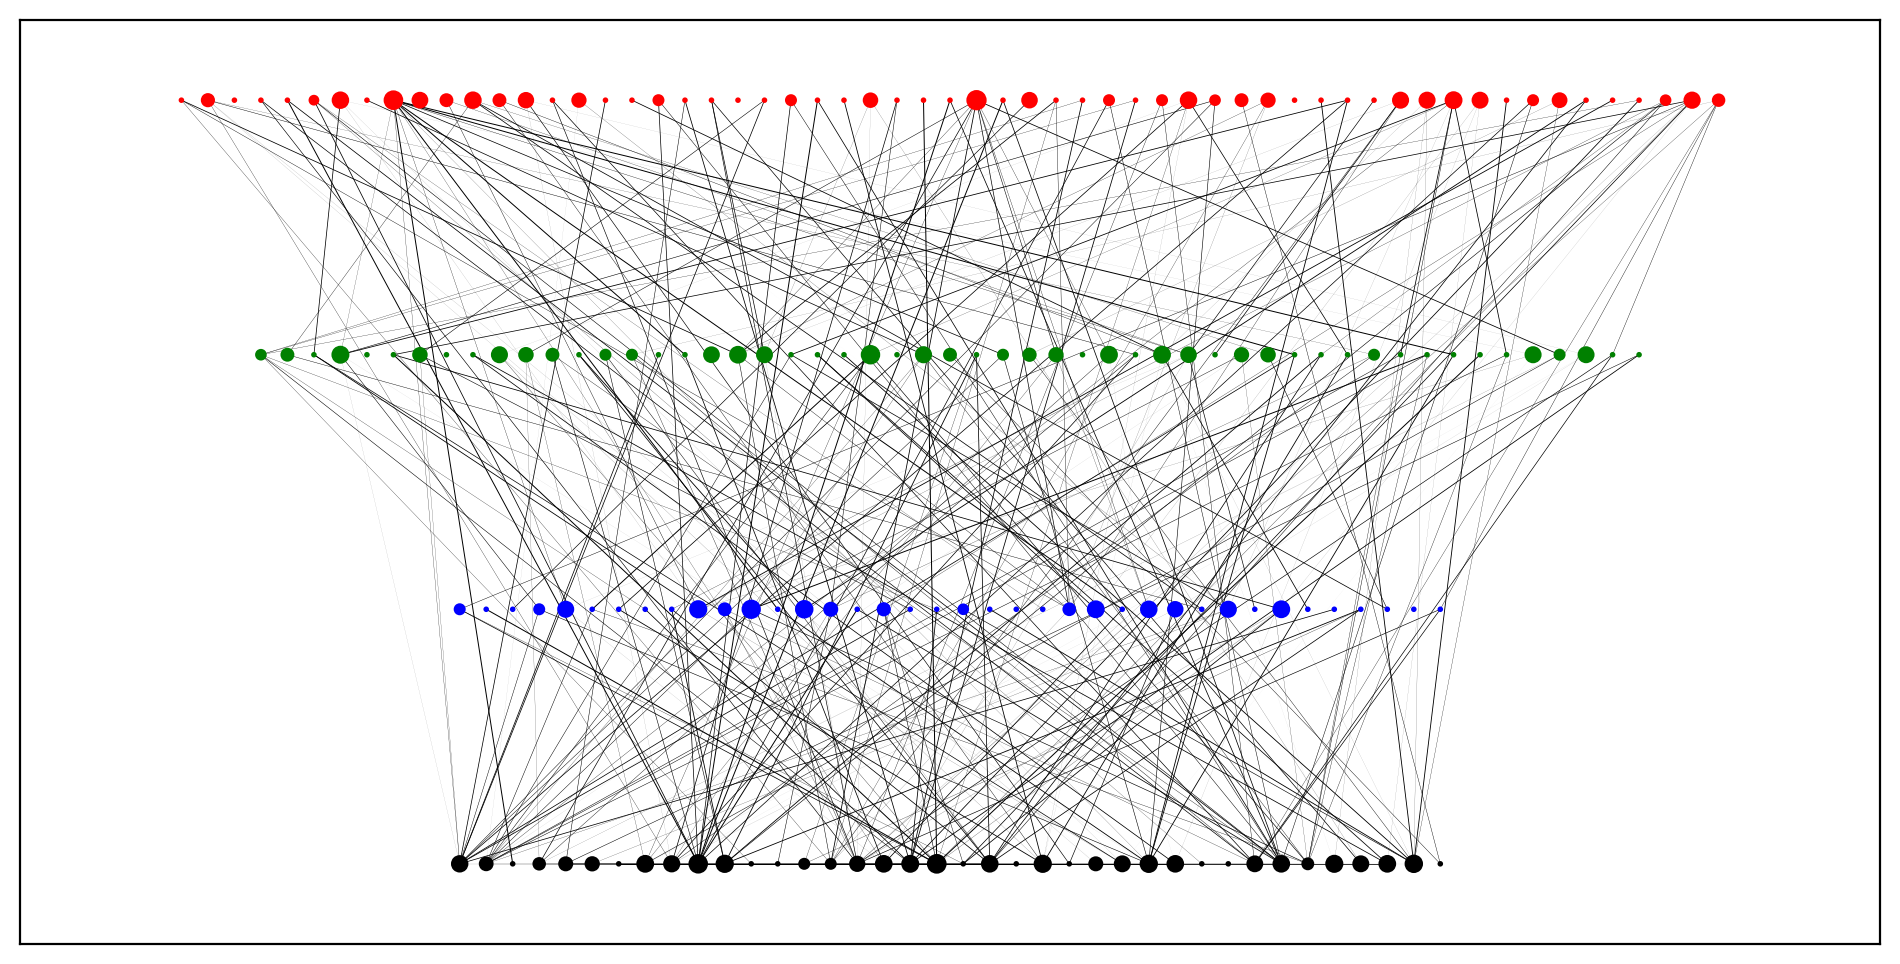

In [20]:
bqm = createBQM(G, phrases, instruments, 1, 12, 1)
sampleset = sampler.sample(bqm, num_reads=3000, label=f"Haydn_{3000}")
plotSampleGraph(sampleset.first.sample, G)

In [4]:
#plotArrangement(sample, phrases, instruments)

def findOverlaps(G: nx.Graph) -> int:
    overlaps = 0
    for (n1, n2) in G.edges:
        if G.nodes[n1]["colour"] == G.nodes[n2]["colour"] and G.nodes[n1]["colour"] != "black":
            overlaps += 1
    return overlaps

#findOverlaps(annotateSampleGraph(sampleset.first.sample, G))

In [ ]:
# Start with both multipliers as 1
# Vary node multiplier to find best
# Vary edge multiplier to find best
# Theoretically no overlaps once both varied

# Edge multiplier = 12 prevents overlaps without increasing energy too much
# Now can vary total anneals
# Compare to energy and total entropy

multipliers = np.arange(5,20,1)

file = pd.DataFrame()
for m in multipliers:
    bqm = createBQM(G, phrases, instruments, 1, m, 1)
    sampleset = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}")
    sample = sampleset.first

    A = annotateSampleGraph(sample.sample, G)
    new_row = pd.DataFrame({
        "Multiplier": [m],
        "Lowest energy": [bqm.energy(sample.sample)],
        "Chain break fraction": [sample.chain_break_fraction],
        "Overlaps": findOverlaps(A)
        })
    
    file = pd.concat([file, new_row])
    
    print(f"Multiplier {m} recorded!")

file.to_csv(path+"edge-mult.csv", index=False, mode="a", header=False)
#recordSample(path+"samples.csv", results, reads)

Multiplier 5 recorded!
Multiplier 6 recorded!
Multiplier 7 recorded!
Multiplier 8 recorded!
Multiplier 9 recorded!
Multiplier 10 recorded!
Multiplier 11 recorded!
Multiplier 12 recorded!
Multiplier 13 recorded!
Multiplier 14 recorded!
Multiplier 15 recorded!
Multiplier 16 recorded!
Multiplier 17 recorded!
Multiplier 18 recorded!
Multiplier 19 recorded!


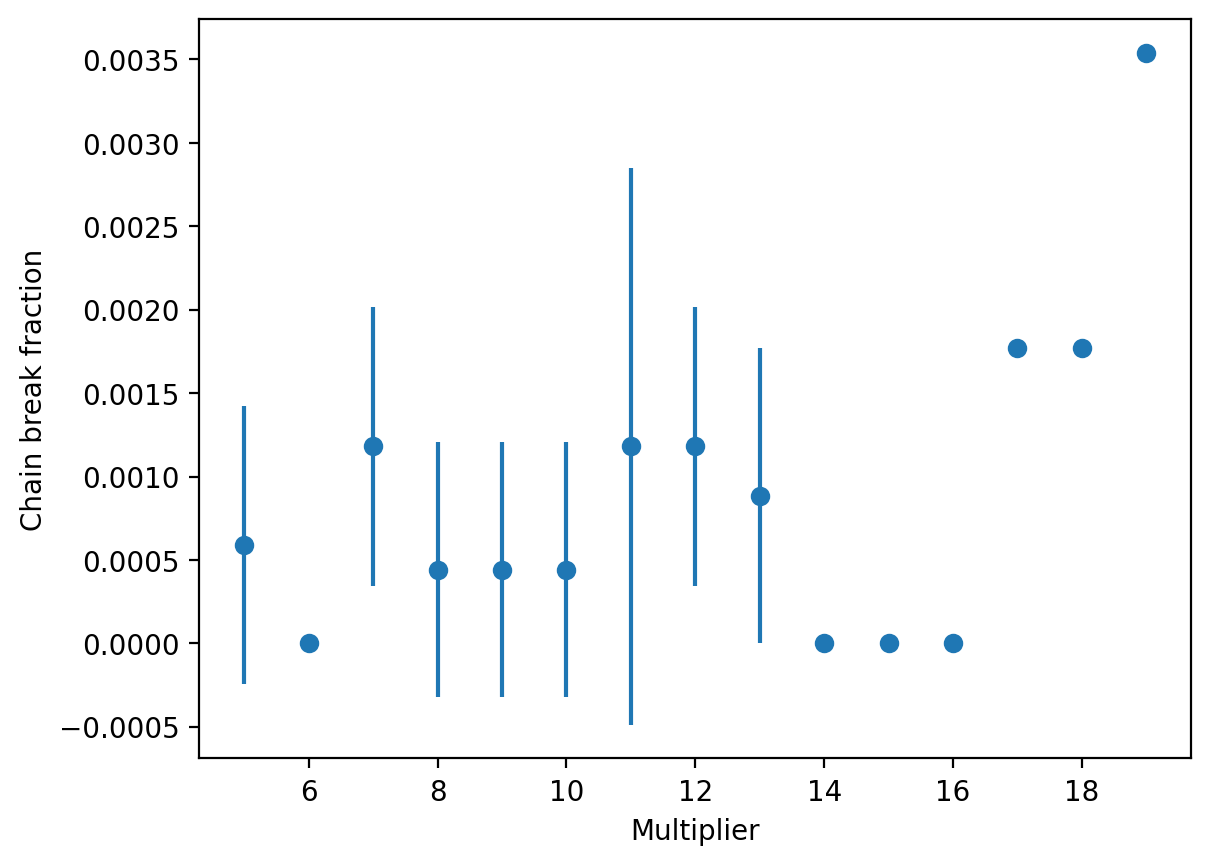

In [21]:
plotCSV(path+"edge-mult.csv", "Multiplier", "Chain break fraction", np.arange(5,20,1))

In [6]:
print(G.nodes.data("entropy"))

[('Violin I_1', 2.7024549619059113), ('Violin I_2', -0.0), ('Violin I_3', 2.7736843762620236), ('Violin I_4', -0.0), ('Violin I_5', 2.6724876891689537), ('Violin I_6', 2.784010874644601), ('Violin I_7', 2.5418848434970744), ('Violin I_8', -0.0), ('Violin I_9', 1.9182958340544893), ('Violin I_10', -0.0), ('Violin I_11', 3.8689641616683996), ('Violin I_12', -0.0), ('Violin I_13', 2.4340437717594363), ('Violin I_14', -0.0), ('Violin I_15', 2.4340437717594363), ('Violin I_16', -0.0), ('Violin I_17', 1.0), ('Violin I_18', -0.0), ('Violin I_19', 1.0), ('Violin I_20', -0.0), ('Violin I_21', 0.7219280948873623), ('Violin I_22', -0.0), ('Violin I_23', 2.364011629520427), ('Violin I_24', -0.0), ('Violin I_25', 1.0), ('Violin I_26', -0.0), ('Violin I_27', 1.0), ('Violin I_28', -0.0), ('Violin I_29', -0.0), ('Violin I_30', -0.0), ('Violin I_31', 2.0), ('Violin I_32', 2.82759912921136), ('Violin I_33', 1.584962500721156), ('Violin I_34', 1.0), ('Violin I_35', -0.0), ('Violin I_36', 2.70245496190591

In [ ]:
no_reads = range(1100, 2001, 100)
repeats = 4

for reads in no_reads:
    for _ in range(repeats):
        results = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}")
        recordSample(path+"samples.csv", results, reads)
    print(f"Recorded {reads} reads")

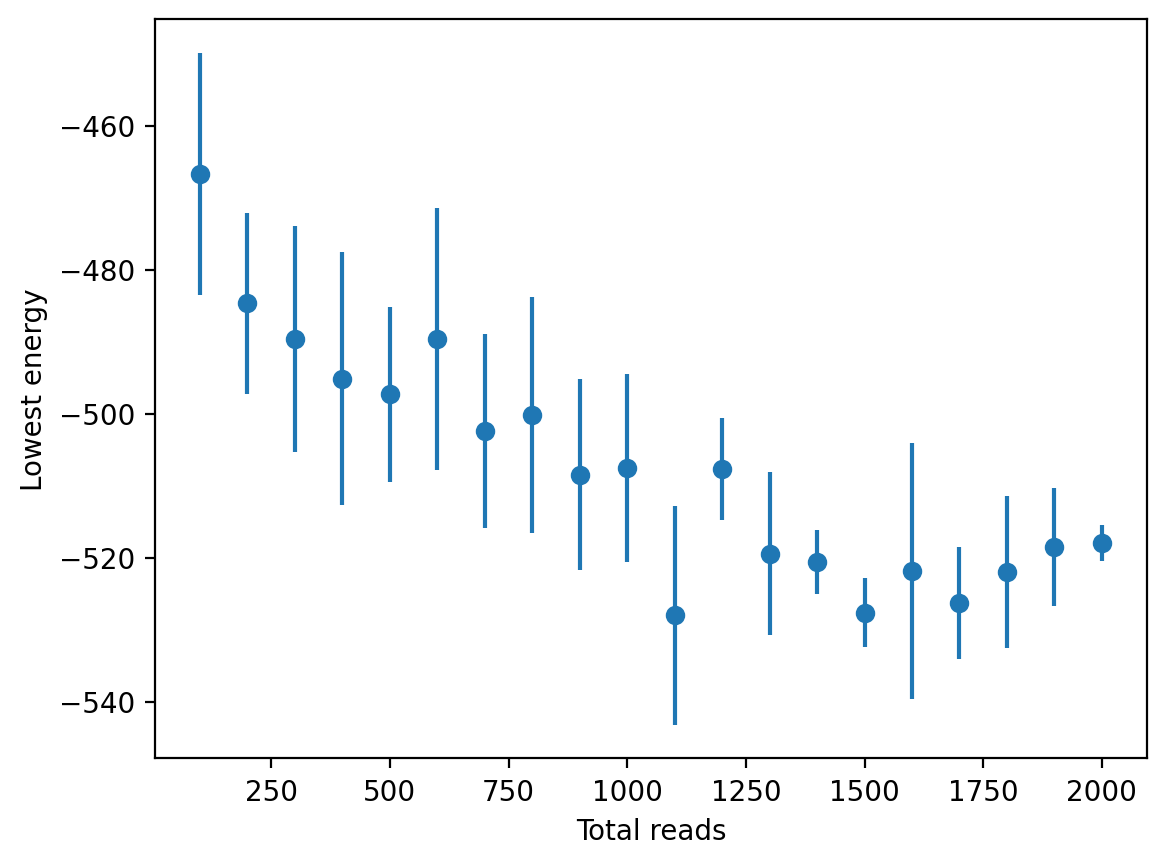

In [ ]:
plotCSV(path+"samples.csv", "Total reads", "Lowest energy", range(100, 2001, 100))

In [ ]:
# Show results

#plotArrangement(sample, phrases, instruments)

In [ ]:
sampler = SimulatedAnnealingSampler()
reads = 1000

results = sampler.sample(bqm, num_reads=reads)
df = results.to_pandas_dataframe(True)

plotSampleGraph(df["sample"][0], G, [phrase for part in phrases for phrase in part])

In [ ]:
# Solve classically

sd = SteepestDescentSolver()
sa = SimulatedAnnealingSampler()

# Compare energies from different methods
# Just because it doesn't crash doesn't mean it passed

for reads in no_reads:
    for _ in range(repeats):
        results = sa.sample(bqm, num_reads=reads)
        new_row = pd.DataFrame({
            "Total reads": [reads],
            "Lowest energy": [results.first.energy],
        })

        new_row.to_csv(path + "simulated.csv", index=False, mode="a", header=False)

    print(f"Recorded {reads} reads")

In [ ]:
simulated = pd.read_csv(path + "simulated.csv")
plotEnergyAgainstReads(simulated)
plotEnergyAgainstReads(samples)

In [ ]:
print(results.info.keys())
print(results.info["embedding_context"]["chain_strength"])
print(results.info["timing"]["qpu_anneal_time_per_sample"])
print(results.info["timing"]["qpu_access_time"])
print(results.info["timing"])
print(results.first.energy)
print(bqm.energy(results.first.sample))
print(results.first.sample)
print(results.first.chain_break_fraction)

In [ ]:
plotHistogram(df)
print(df.head())
print(bqm.energy(df["sample"][0]))

In [ ]:
chain_strengths = [10, 20, 30, 40, 50, 60, 70, 80, 90]
sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
reads = 500
anneal_time = 400

for cs in chain_strengths:
    sampleset = sampler.sample(bqm, num_reads=reads, annealing_time=300, chain_strength=cs, label=f"Haydn_{reads}r_{anneal_time}us").to_pandas_dataframe(True)
    plt.subplot(3, 3, chain_strengths.index(cs)+1, sharex=True, sharey=True)
    plt.title(f"Chain Strength: {cs}")
    plotHistogram(sampleset)

plt.show()

In [ ]:

#arrangement.write(fmt="musicxml.pdf", fp="../Figures/poly.pdf", dpi=300)

# TODO: Create measure of constraint breaking (adjacent colours not same)
# 

# TODO: Bias selection of phrases to specific parts (e.g. by checking ambitus)
# TODO: Add meaningful edge weightings
# TODO: Are there more efficient ways to add constraints?